<a href="https://colab.research.google.com/github/tasmimjoti/Computer-Vision/blob/main/Brain_tumor_detection_using_CNN_and_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Required Libraries**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, Input, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# **Dataset Loading**

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/Testing'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())

Found 5722 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# **Defining Function for Evaluation Metrics**

In [ ]:
def evaluate_model(model, test_generator, model_name, class_names):
    print(f"\n--- Evaluation for {model_name} ---")
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_generator.classes

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def show_sample_predictions(model, generator, class_names, num_samples=5):
    x_test, y_test = next(generator)
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(x_test[i])
        true_label = class_names[y_true_classes[i]]
        pred_label = class_names[y_pred_classes[i]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


def plot_multiclass_roc(model, test_generator, class_names, model_name):
    # Get ground truth and predictions
    Y_pred = model.predict(test_generator)
    y_score = Y_pred

    # One-hot true labels from the generator
    y_true = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC for each class
    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], label=f"{class_name} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# **Training CNN**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.4993 - loss: 3.7360 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 3937s 22s/step - accuracy: 0.4995 - loss: 3.7260 - val_accuracy: 0.4050 - val_loss: 1.4657
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 425ms/step - accuracy: 0.5412 - loss: 1.1359 - val_accuracy: 0.4241 - val_loss: 1.2511
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 423ms/step - accuracy: 0.5845 - loss: 1.0083 - val_accuracy: 0.5858 - val_loss: 1.0237
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 419ms/step - accuracy: 0.5936 - loss: 0.9835 - val_accuracy: 0.6766 - val_loss: 0.8890
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 417ms/step - accuracy: 0.5881 - loss: 0.9654 - val_accuracy: 0.6773 - val_loss: 0.9692
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 420ms/step - accuracy: 0.6431 - loss: 0.8552 - val_accuracy: 0.6834 - val_loss: 1.0169
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 418ms/step - accuracy: 0.6207 - loss: 0.8487 - val_accuracy: 0.6964 - val_loss: 1.2234
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 417ms/step - accuracy: 0.6391 - loss: 0.8646 - val

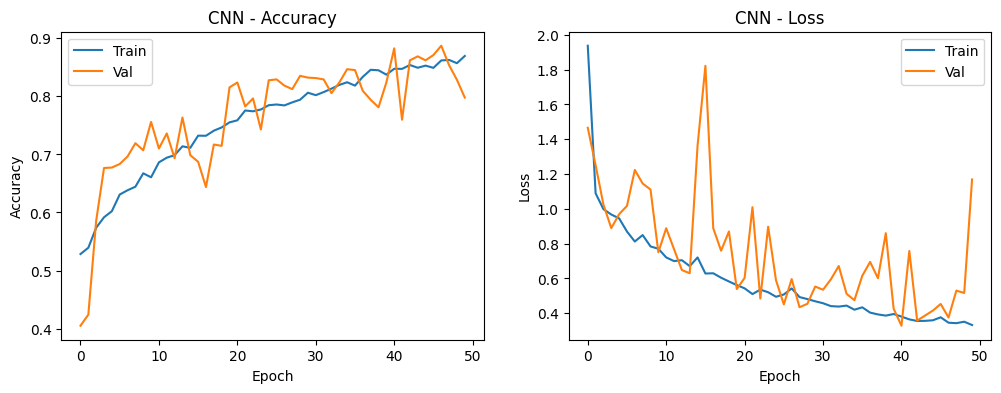


--- Evaluation for CNN ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step

Classification Report:

              precision    recall  f1-score   support

      glioma       0.79      0.87      0.83       300
  meningioma       0.86      0.28      0.43       306
     notumor       0.90      0.99      0.94       405
   pituitary       0.69      1.00      0.81       300

    accuracy                           0.80      1311
   macro avg       0.81      0.78      0.75      1311
weighted avg       0.82      0.80      0.77      1311



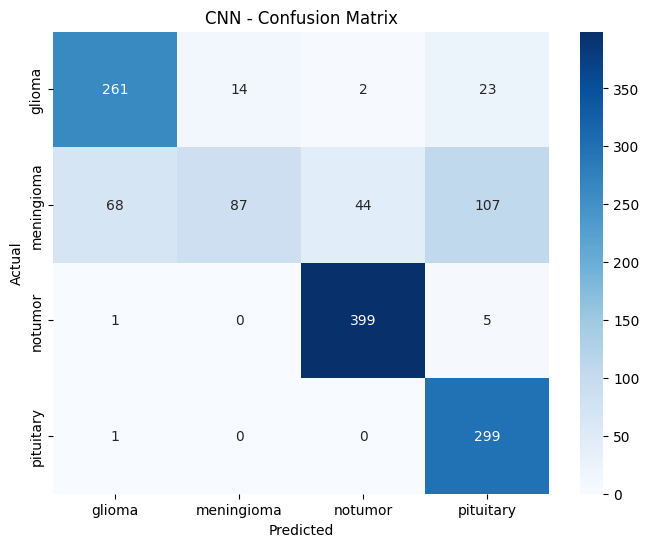

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


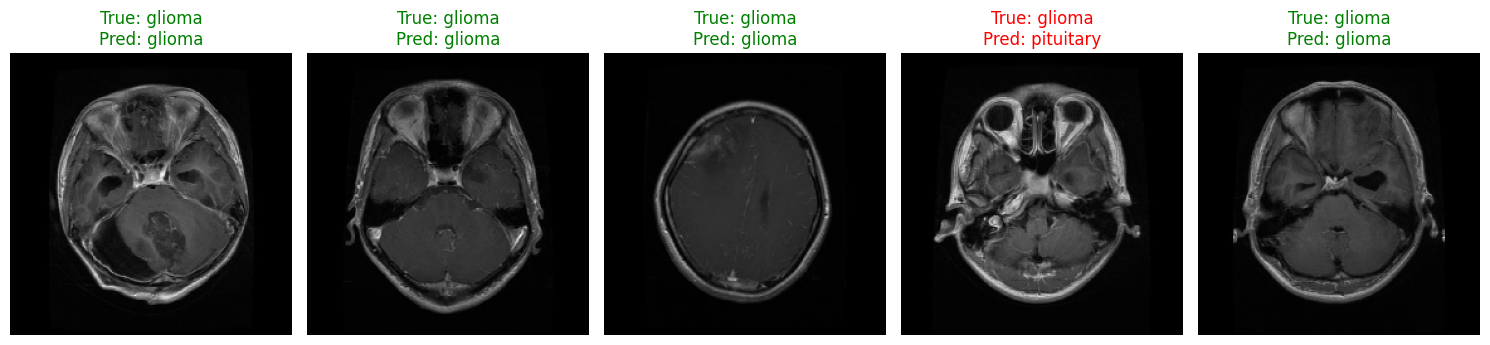

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step


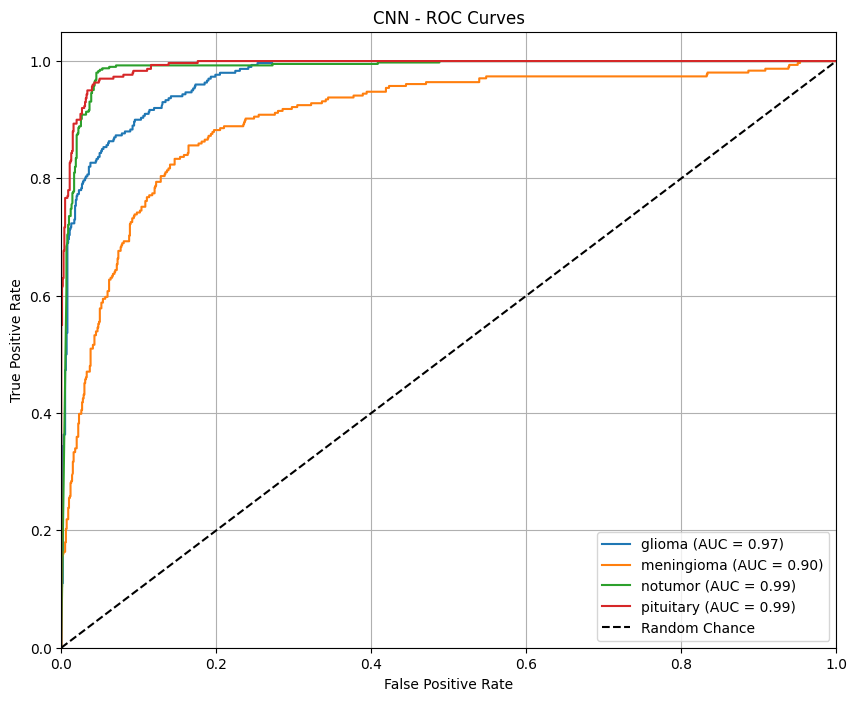

In [ ]:
def create_custom_cnn(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = create_custom_cnn(input_shape=IMG_SIZE + (3,))
custom_cnn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history_custom = custom_cnn.fit(train_generator, validation_data=test_generator, epochs=EPOCHS)
plot_history(history_custom, 'CNN')
evaluate_model(custom_cnn, test_generator, 'CNN', class_names)
show_sample_predictions(custom_cnn, test_generator, class_names)
plot_multiclass_roc(custom_cnn, test_generator, class_names, 'CNN')

## **Transfer Learning Models Definition**

In [ ]:
def create_transfer_model(base_model_class, preprocess_fn, input_shape=(224, 224, 3), num_classes=4):
    base_model = base_model_class(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = preprocess_fn(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# **Training VGG16**

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 453ms/step - accuracy: 0.2586 - loss: 2.1511 - val_accuracy: 0.3799 - val_loss: 1.3084
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 419ms/step - accuracy: 0.3286 - loss: 1.3252 - val_accuracy: 0.3806 - val_loss: 1.2785
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 419ms/step - accuracy: 0.3490 - loss: 1.2807 - val_accuracy: 0.3814 - val_loss: 1.2694
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 421ms/step - accuracy: 0.3753 - loss: 1.2533 - val_accuracy: 0.3791 - val_loss: 1.2588
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 420ms/step - accuracy: 0.3853 - loss: 1.2537 - val_accuracy: 0.3532 - val_loss: 1.2552
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 419ms/step - accuracy: 0.3694 - loss: 1.2554 - val_accuracy: 0.3806 - val_loss: 1.2565
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 419ms/step - accuracy: 0.3903 - loss: 1.2394 - val_accuracy: 0.3844 - val_loss: 1.2462
Epoch 8/50
179/179 ━━━━━━━━━━━━━

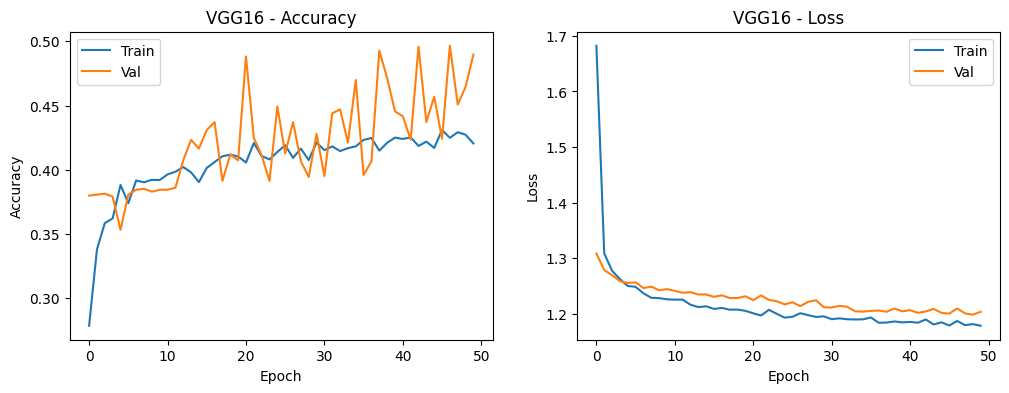


--- Evaluation for VGG16 ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step

Classification Report:

              precision    recall  f1-score   support

      glioma       0.43      0.65      0.52       300
  meningioma       0.42      0.06      0.10       306
     notumor       0.66      0.65      0.65       405
   pituitary       0.41      0.55      0.47       300

    accuracy                           0.49      1311
   macro avg       0.48      0.48      0.43      1311
weighted avg       0.49      0.49      0.45      1311



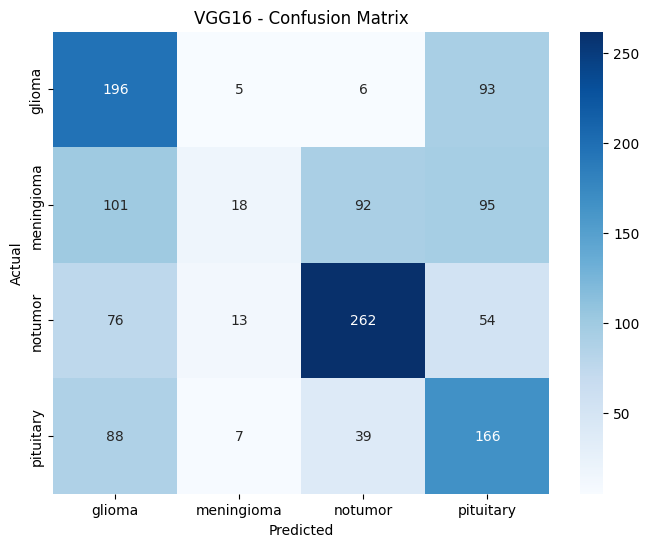

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


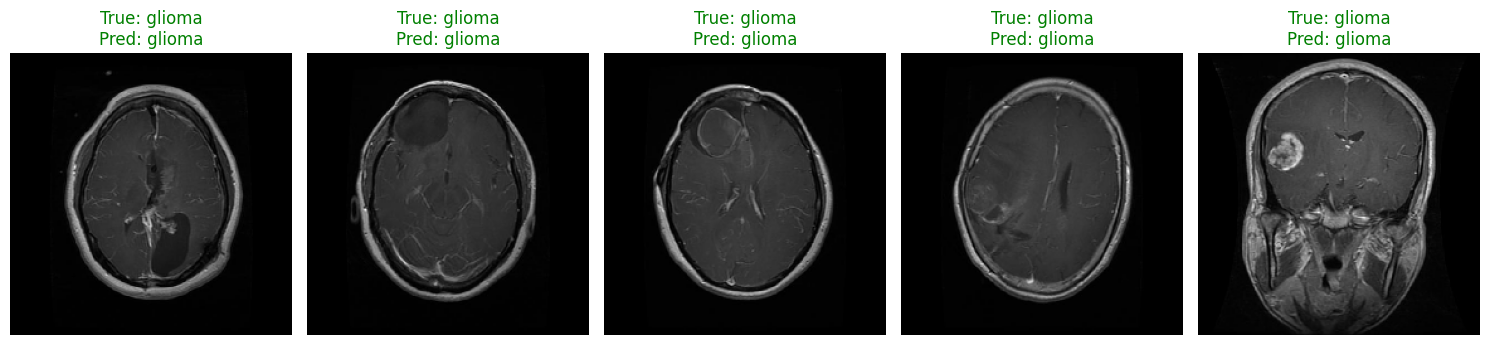

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step


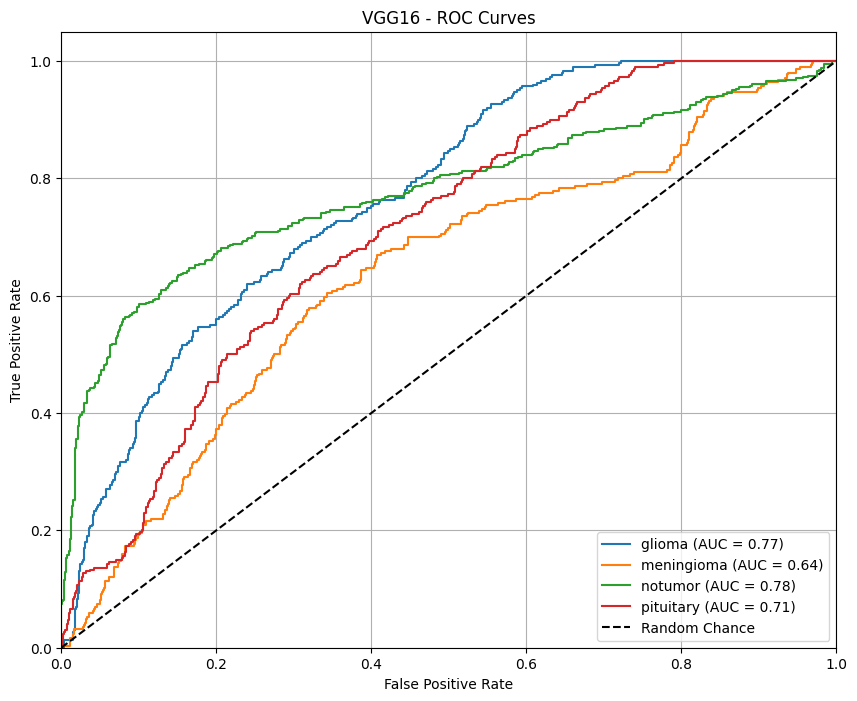

In [ ]:
vgg_model = create_transfer_model(VGG16, vgg_preprocess)
vgg_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg = vgg_model.fit(train_generator, validation_data=test_generator, epochs=EPOCHS)
plot_history(history_vgg, 'VGG16')
evaluate_model(vgg_model, test_generator, 'VGG16', class_names)
show_sample_predictions(vgg_model, test_generator, class_names)
plot_multiclass_roc(vgg_model, test_generator, class_names, 'VGG16')

# **Training ResNet50**

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 99s 492ms/step - accuracy: 0.3451 - loss: 1.4377 - val_accuracy: 0.4905 - val_loss: 1.2001
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 434ms/step - accuracy: 0.4668 - loss: 1.1744 - val_accuracy: 0.5225 - val_loss: 1.1563
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 434ms/step - accuracy: 0.5101 - loss: 1.1260 - val_accuracy: 0.5507 - val_loss: 1.1200
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 433ms/step - accuracy: 0.5431 - loss: 1.0712 - val_accuracy: 0.5683 - val_loss: 1.0996
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 435ms/step - accuracy: 0.5415 - loss: 1.0633 - val_accuracy: 0.5294 - val_loss: 1.0818
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 428ms/step - accuracy: 0.5675 - loss: 1.0293 - val_accuracy: 0.5706 - val_loss: 1.0820
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 74s 416ms/step - accuracy: 0.5655 - loss: 1.0272 - val_accuracy: 0.5713 - val_loss: 1.0619
Epoch 8/50
179/179 ━━━━━━━━━━━━━

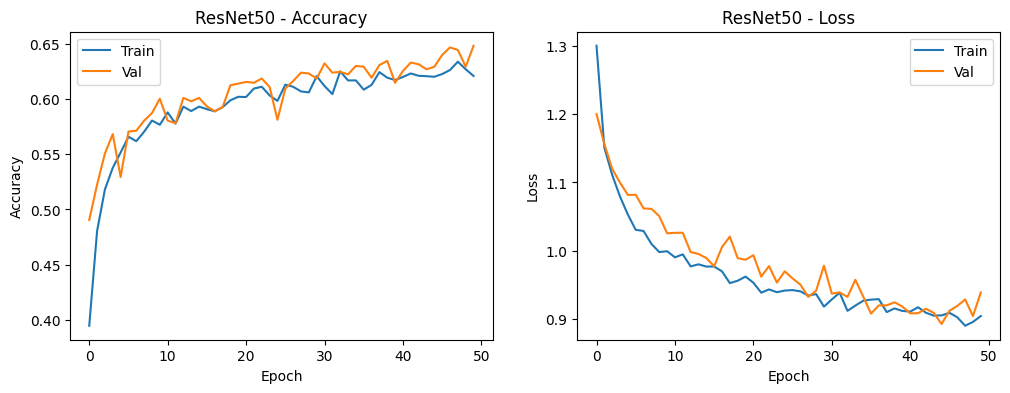


--- Evaluation for ResNet50 ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step

Classification Report:

              precision    recall  f1-score   support

      glioma       0.67      0.47      0.55       300
  meningioma       0.52      0.34      0.41       306
     notumor       0.72      0.87      0.79       405
   pituitary       0.62      0.83      0.71       300

    accuracy                           0.65      1311
   macro avg       0.63      0.63      0.62      1311
weighted avg       0.64      0.65      0.63      1311



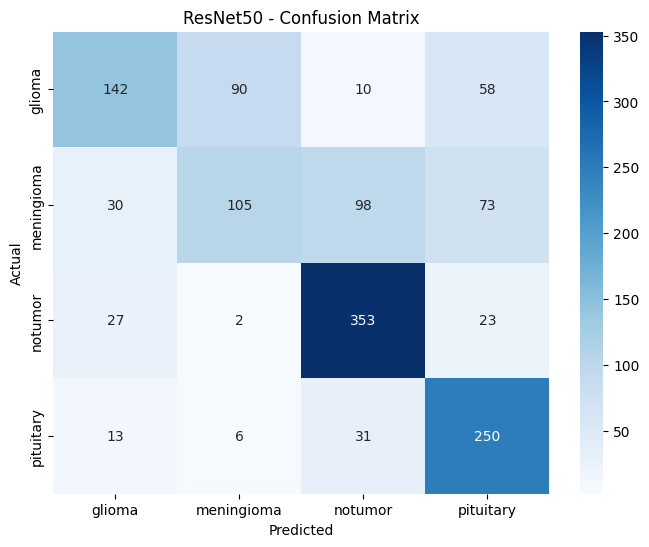

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


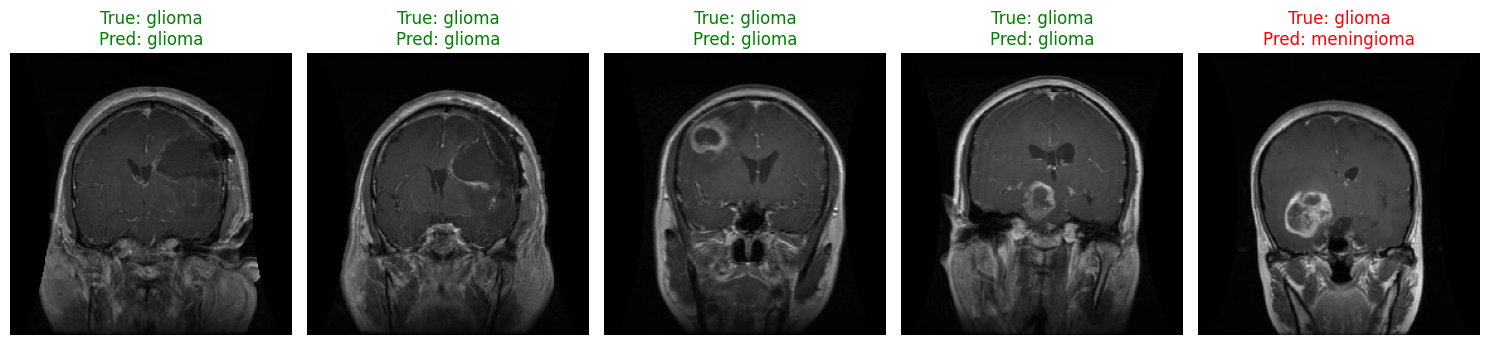

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step


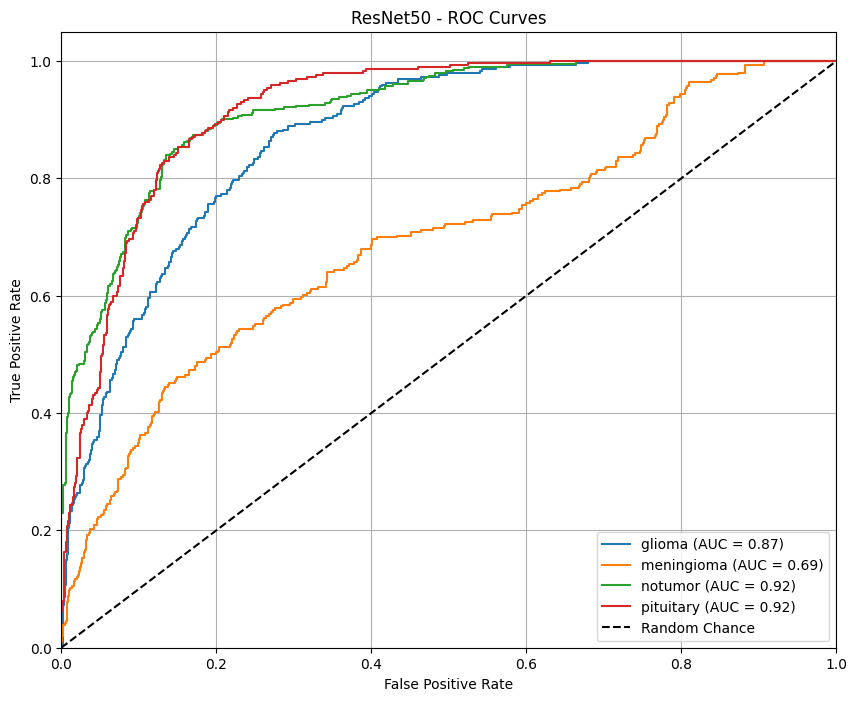

In [ ]:
resnet_model = create_transfer_model(ResNet50, resnet_preprocess)
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet = resnet_model.fit(train_generator, validation_data=test_generator, epochs=EPOCHS)
plot_history(history_resnet, 'ResNet50')
evaluate_model(resnet_model, test_generator, 'ResNet50', class_names)
show_sample_predictions(resnet_model, test_generator, class_names)
plot_multiclass_roc(resnet_model, test_generator, class_names, 'ResNet50')

# **Training InceptionV3**

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 106s 516ms/step - accuracy: 0.4553 - loss: 1.1636 - val_accuracy: 0.6087 - val_loss: 0.9688
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 425ms/step - accuracy: 0.5750 - loss: 0.9678 - val_accuracy: 0.6095 - val_loss: 0.9552
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 424ms/step - accuracy: 0.6131 - loss: 0.9039 - val_accuracy: 0.6217 - val_loss: 0.8943
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 423ms/step - accuracy: 0.6136 - loss: 0.8885 - val_accuracy: 0.6568 - val_loss: 0.8877
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 421ms/step - accuracy: 0.6313 - loss: 0.8672 - val_accuracy: 0.6636 - val_loss: 0.8807
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 425ms/step - accuracy: 0.6357 - loss: 0.8642 - val_accuracy: 0.6720 - val_loss: 0.8292
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 76s 424ms/step - accuracy: 0.6374 - loss: 0.8543 - val_accuracy: 0.6499 - val_loss: 0.8766
Epoch 8/50
179/179 ━━━━━━━━━━━━

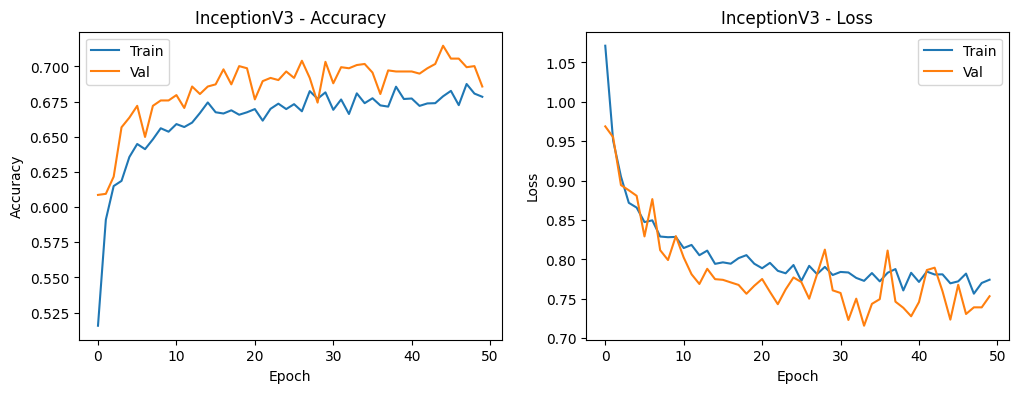


--- Evaluation for InceptionV3 ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step

Classification Report:

              precision    recall  f1-score   support

      glioma       0.73      0.39      0.51       300
  meningioma       0.45      0.59      0.51       306
     notumor       0.80      0.89      0.84       405
   pituitary       0.80      0.81      0.80       300

    accuracy                           0.69      1311
   macro avg       0.70      0.67      0.67      1311
weighted avg       0.70      0.69      0.68      1311



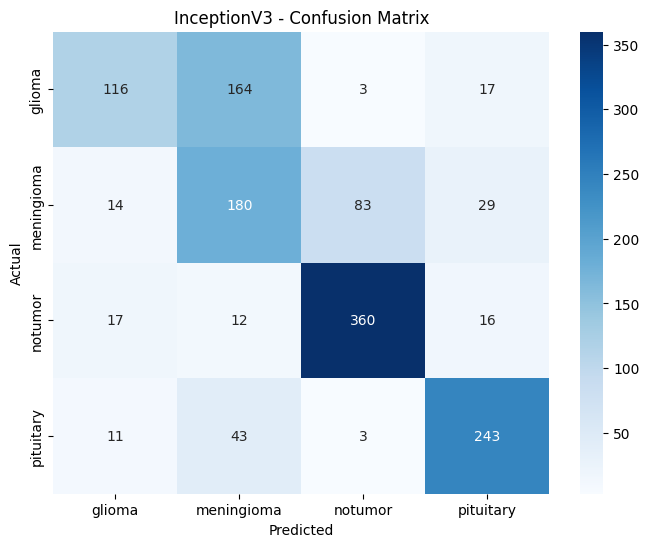

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


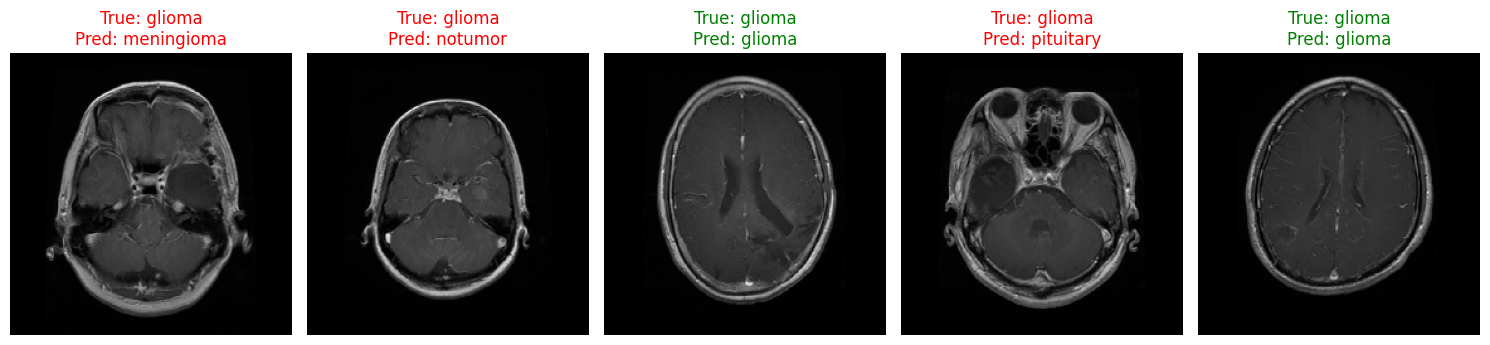

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step


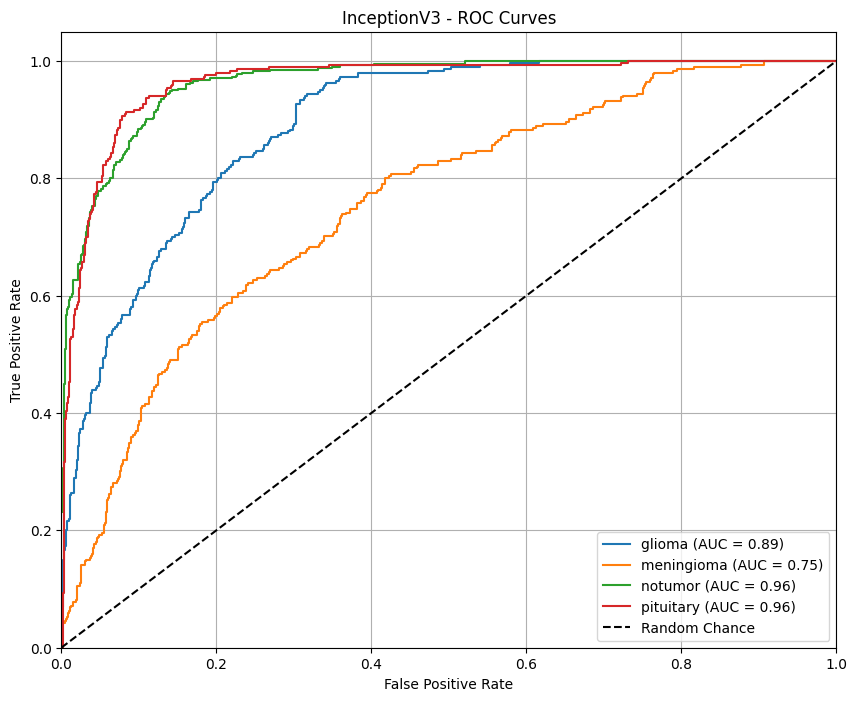

In [ ]:
inception_model = create_transfer_model(InceptionV3, inception_preprocess)
inception_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history_inception = inception_model.fit(train_generator, validation_data=test_generator, epochs=EPOCHS)
plot_history(history_inception, 'InceptionV3')
evaluate_model(inception_model, test_generator, 'InceptionV3', class_names)
show_sample_predictions(inception_model, test_generator, class_names)
plot_multiclass_roc(inception_model, test_generator, class_names, 'InceptionV3')